In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
torch.manual_seed(42)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
device

device(type='cuda')

In [8]:
df = pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(60000, 785)

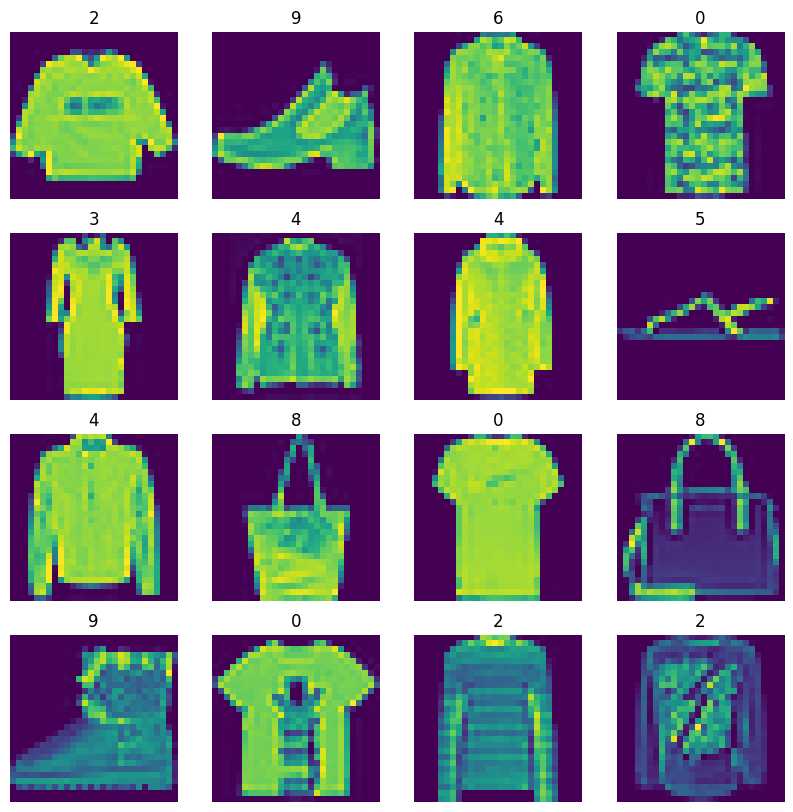

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
  img = df.iloc[i, 1:].values.reshape(28, 28)
  ax.imshow(img)
  ax.set_title(df.iloc[i, 0])
  ax.axis('off')

In [11]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# transformation in the data
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.458, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [14]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize image (28 x 28)
    image = self.features[index].reshape(28, 28)

    # change dtype to np.unit8
    image = image.astype(np.uint8)

    # change into 3 block or black&white  and (H, W, C) -> (C, H, W)
    image = np.stack([image]*3, axis=-1)

    # convert array to PTI image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return index data
    return image, torch.tensor(self.labels[index], dtype=torch.long)

In [15]:
train_dataset = CustomDataset(X_train, y_train, transform=custom_transform)
test_dataset = CustomDataset(X_test, y_test, transform=custom_transform)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [17]:
# fetch the pretrained model
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 75.1MB/s]


In [18]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
# now we freez the features parts form the model so it didn't update
for param in vgg16.features.parameters():
  param.requires_grad = False


In [20]:
# then replacing the classifier part with our new one

vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=1024, out_features= 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=10)
)

In [21]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
vgg16 = vgg16.to(device)

In [23]:
learning_rate = 0.0001
epochs = 10

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [25]:
for epoch in range(epochs):
  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    output = vgg16(batch_features)

    loss = criterion(output, batch_labels)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    total_epoch_loss += loss.item()

  avg_loss = total_epoch_loss / len(train_loader)
  print(f"Epoch: {epoch}, Loss: {avg_loss}")




Epoch: 0, Loss: 0.3660893961948653
Epoch: 1, Loss: 0.21698229841391245
Epoch: 2, Loss: 0.1681367197148502
Epoch: 3, Loss: 0.129691944969818
Epoch: 4, Loss: 0.10535325815582959
Epoch: 5, Loss: 0.08337781880889088
Epoch: 6, Loss: 0.06805883104656824
Epoch: 7, Loss: 0.05500008339751124
Epoch: 8, Loss: 0.04744572838380554
Epoch: 9, Loss: 0.04075031762945097


In [26]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
# evaluation

total = 0
correct = 0

with torch.no_grad():


  for batch_features, batch_labels in test_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    output = vgg16(batch_features)

    _, predicted = torch.max(output, dim=1)

    total += batch_labels.shape[0]

    correct += (predicted == batch_labels).sum().item()

  print(correct / total)

0.9285833333333333
